STAT 453: Deep Learning (Spring 2020)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2020/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss20

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch,pandas,matplotlib

Sebastian Raschka 

CPython 3.7.5
IPython 7.10.2

torch 1.4.0
pandas 0.25.3
matplotlib 3.1.1


# ADALINE with Stochastic Gradient Descent (Minibatch)

![](figures/adaline-concept.png)

In this notebook, we are implementing ADALINE "by hand" without using PyTorch's autograd capabilities. In Lecture 06, we will use "automatic differentiation" (also known as "autodiff"; or autograd in PyTorch) to implement Adaline more compactly. (The reason why we don't use autodiff here is that it is useful to understand what's going on under the hood.) 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
%matplotlib inline

<br>
<br>

## Load & Prepare a Toy Dataset

In [3]:
df = pd.read_csv('ENB2012_data.csv', index_col=None)
# df.columns = ['x1', 'x2', 'x3', 'x4', 'y']
# df = df.iloc[50:150]
# Note : 24 is the mean of Y2 feature
df['Y2'] = df['Y2'].apply(lambda x: 0 if x > 24 else 1)
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,1
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,1
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,1
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,1
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,0


In [4]:
# Assign features and target

X = torch.tensor(df.drop(columns=["Y1", "Y2"]).values, dtype=torch.float)
y = torch.tensor(df['Y2'].values, dtype=torch.int)

# Shuffling & train/test split

torch.manual_seed(42)
shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)

X, y = X[shuffle_idx], y[shuffle_idx]

percent80 = int(shuffle_idx.size(0)*0.8)

X_train, X_test = X[shuffle_idx[:percent80]], X[shuffle_idx[percent80:]]
y_train, y_test = y[shuffle_idx[:percent80]], y[shuffle_idx[percent80:]]

# Normalize (mean zero, unit variance)

mu, sigma = X_train.mean(dim=0), X_train.std(dim=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

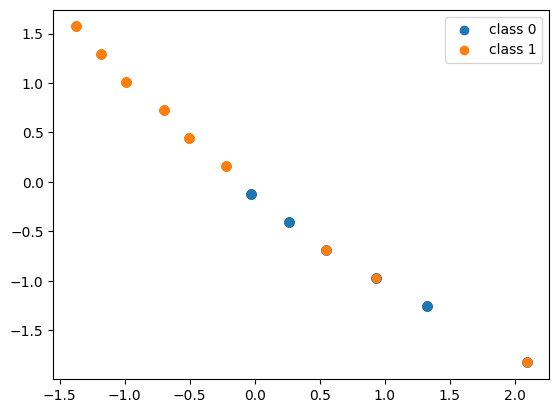

In [5]:
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], label='class 0')
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], label='class 1')
plt.legend()
plt.show()

<br>
<br>

## Implement ADALINE Model

In [6]:
class Adaline1():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(num_features, 1, 
                                   dtype=torch.float)
        self.bias = torch.zeros(1, dtype=torch.float)

    def forward(self, x):
        netinputs = torch.add(torch.mm(x, self.weights), self.bias)
        activations = netinputs
        return activations.view(-1)
        
    def backward(self, x, yhat, y):  
        
        grad_loss_yhat = 2*(y - yhat)
        
        grad_yhat_weights = -x
        grad_yhat_bias = -1.
        
        # Chain rule: inner times outer
        grad_loss_weights =  torch.mm(grad_yhat_weights.t(),
                                         grad_loss_yhat.view(-1, 1)) / y.size(0)

        grad_loss_bias = torch.sum(grad_yhat_bias*grad_loss_yhat) / y.size(0)
        
        # return negative gradient
        return (-1)*grad_loss_weights, (-1)*grad_loss_bias

<br>
<br>

## Define Training and Evaluation Functions

In [7]:
####################################################
##### Training and evaluation wrappers
###################################################

def loss(yhat, y):
    return torch.mean((yhat - y)**2)


def train(model, x, y, num_epochs,
          learning_rate=0.01, seed=42, minibatch_size=10):
    cost = []
    
    torch.manual_seed(seed)
    for e in range(num_epochs):
        
        #### Shuffle epoch
        shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)
        minibatches = torch.split(shuffle_idx, minibatch_size)
        
        for minibatch_idx in minibatches:

            #### Compute outputs ####
            yhat = model.forward(x[minibatch_idx])

            #### Compute gradients ####
            negative_grad_w, negative_grad_b = \
                model.backward(x[minibatch_idx], yhat, y[minibatch_idx])

            #### Update weights ####
            model.weights += learning_rate * negative_grad_w
            model.bias += learning_rate * negative_grad_b
            
            #### Logging ####
            minibatch_loss = loss(yhat, y[minibatch_idx])
            print('    Minibatch MSE: %.3f' % minibatch_loss)

        #### Logging ####
        yhat = model.forward(x)
        curr_loss = loss(yhat, y)
        print('Epoch: %03d' % (e+1), end="")
        print(' | MSE: %.5f' % curr_loss)
        cost.append(curr_loss)

    return cost

<br>
<br>

## Train Model

In [8]:
model = Adaline1(num_features=X_train.size(1))
cost = train(model, 
             X_train, y_train.float(),
             num_epochs=500,
             learning_rate=0.01,
             seed=123,
             minibatch_size=10)

    Minibatch MSE: 0.600
    Minibatch MSE: 0.460
    Minibatch MSE: 0.595
    Minibatch MSE: 0.373
    Minibatch MSE: 0.287
    Minibatch MSE: 0.324
    Minibatch MSE: 0.359
    Minibatch MSE: 0.334
    Minibatch MSE: 0.292
    Minibatch MSE: 0.152
    Minibatch MSE: 0.310
    Minibatch MSE: 0.195
    Minibatch MSE: 0.127
    Minibatch MSE: 0.296
    Minibatch MSE: 0.121
    Minibatch MSE: 0.133
    Minibatch MSE: 0.190
    Minibatch MSE: 0.142
    Minibatch MSE: 0.074
    Minibatch MSE: 0.063
    Minibatch MSE: 0.155
    Minibatch MSE: 0.149
    Minibatch MSE: 0.131
    Minibatch MSE: 0.337
    Minibatch MSE: 0.139
    Minibatch MSE: 0.131
    Minibatch MSE: 0.154
    Minibatch MSE: 0.145
    Minibatch MSE: 0.270
    Minibatch MSE: 0.120
    Minibatch MSE: 0.057
    Minibatch MSE: 0.091
    Minibatch MSE: 0.177
    Minibatch MSE: 0.092
    Minibatch MSE: 0.069
    Minibatch MSE: 0.058
    Minibatch MSE: 0.041
    Minibatch MSE: 0.099
    Minibatch MSE: 0.075
    Minibatch MSE: 0.094


<br>
<br>

## Evaluate ADALINE Model

### Plot Loss (MSE)

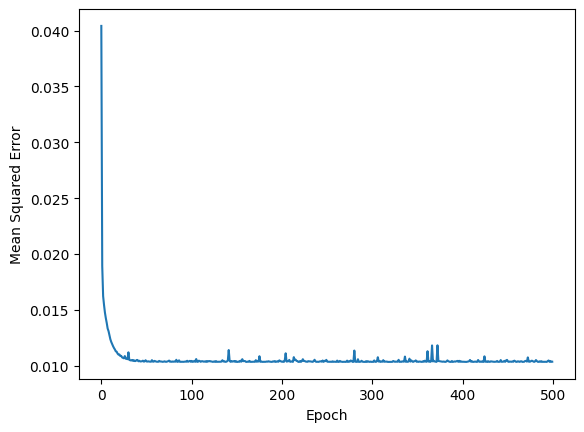

In [9]:
plt.plot(range(len(cost)), cost)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()

<br>
<br>

### Compare with analytical solution

In [9]:
print('Weights', model.weights)
print('Bias', model.bias)

Weights tensor([[ 0.0684],
        [ 0.0428],
        [ 0.0065],
        [ 0.0379],
        [-0.4757],
        [-0.0030],
        [-0.0139],
        [-0.0156]])
Bias tensor([0.5185])


In [10]:
def analytical_solution(x, y):
    Xb = torch.cat( (torch.ones((x.size(0), 1)), x), dim=1)
    w = torch.zeros(x.size(1))
    z = torch.inverse(torch.matmul(Xb.t(), Xb))
    params = torch.matmul(z, torch.matmul(Xb.t(), y))
    b, w = torch.tensor([params[0]]), params[1:].view(x.size(1), 1)
    return w, b

w, b = analytical_solution(X_train, y_train.float())
print('Analytical weights', w)
print('Analytical bias', b)

Analytical weights tensor([[ 7.3833e-02],
        [ 2.6962e+01],
        [-1.3729e+01],
        [-2.8088e+01],
        [-4.0703e-01],
        [ 4.2073e-04],
        [ 3.8079e-01],
        [-1.2771e-02]])
Analytical bias tensor([0.5195])


<br>
<br>

## Evaluate on Evaluation Metric (Prediction Accuracy)

In [11]:
ones = torch.ones(y_train.size())
zeros = torch.zeros(y_train.size())
train_pred = model.forward(X_train)
train_acc = torch.mean(
    (torch.where(train_pred > 0.5, 
                 ones, 
                 zeros).int() == y_train).float())

ones = torch.ones(y_test.size())
zeros = torch.zeros(y_test.size())
test_pred = model.forward(X_test)
test_acc = torch.mean(
    (torch.where(test_pred > 0.5, 
                 ones, 
                 zeros).int() == y_test).float())

print('Training Accuracy: %.2f' % (train_acc*100))
print('Test Accuracy: %.2f' % (test_acc*100))
print("Priyanka Engu")
print(856540215)

Training Accuracy: 98.86
Test Accuracy: 98.70
Priyanka Engu
856540215


<br>
<br>

## Decision Boundary

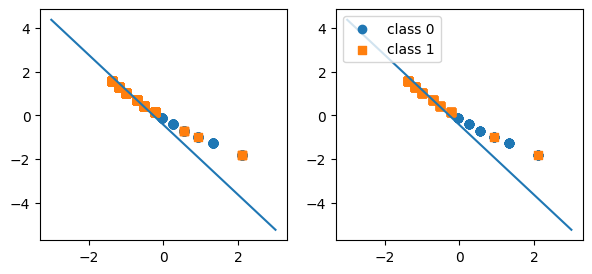

Priyanka Engu
856540215


In [12]:
##########################
### 2D Decision Boundary
##########################

w, b = model.weights, model.bias - 0.5

x_min = -3
y_min = ( (-(w[0] * x_min) - b[0]) 
          / w[1] )

x_max = 3
y_max = ( (-(w[0] * x_max) - b[0]) 
          / w[1] )


fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))

ax[0].plot([x_min, x_max], [y_min[0], y_max[0]])
ax[1].plot([x_min, x_max], [y_min[0], y_max[0]])

ax[0].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
ax[0].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')

ax[1].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='class 0', marker='o')
ax[1].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='class 1', marker='s')

ax[1].legend(loc='upper left')
plt.show()
print("Priyanka Engu")
print(856540215)